# PA2: 3D Bounding Box

实现`Graham法(求凸包)`和`旋转卡壳`求点云的最小外接矩形, 辅助函数和整体框架已实现, 请填补`get_convex_hull`和`get_min_box`函数中缺失的部分, 最终效果如下图:
![pa2_show1](./data/pa2_show1.png)
![pa2_show2](./data/pa2_show2.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


`get_convex_hull`函数接收[N, 2]点集`pts`, 输出凸包顶点列表.
1. 选择一个凸包上的点(例如y最小的点)作为起始点.
2. 其余点按照与起始点连线的夹角排序(极角排序).
3. 按顺序枚举点, 若当前点和栈内最后一个点构成凹角则丢弃栈内最后的点, 否则将当前点入栈.

In [2]:
def get_convex_hull(pts):
    start_idx = np.argmin(pts[:, 1])
    # Q1: calculate theta and sort all points in increasing order of angle
    theta = np.arctan2(pts[:, 1] - pts[start_idx, 1], pts[:, 0] - pts[start_idx, 0])
    sorted_indices = np.argsort(theta)
    convex_hull = [start_idx]
    for idx in sorted_indices:
        if idx == start_idx:
            continue
        while len(convex_hull) > 1:
            p = pts[idx]
            pc_1 = pts[convex_hull[-1]]
            pc_2 = pts[convex_hull[-2]]
            # Q2: condition for discarding the last point
            cond = np.cross(pc_1 - pc_2, p - pc_1) <= 0
            if cond:
                convex_hull.pop()
            else:
                break
        convex_hull.append(idx)
    return convex_hull


运行下面代码块检查生成凸包的正确性.

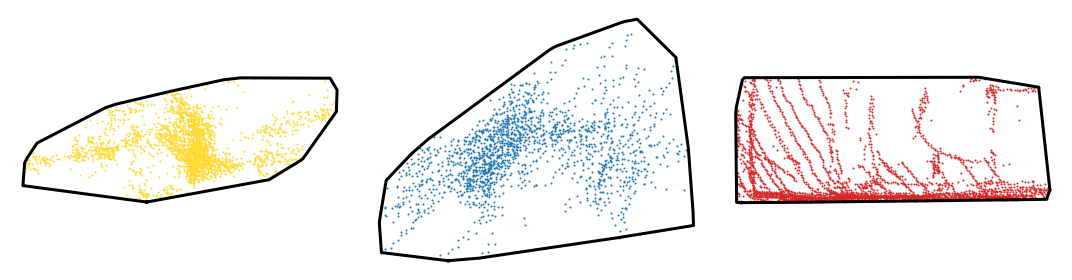

In [3]:
axes = plt.subplots(1, 3, figsize=(15, 4))[1]
cdict = dict(
    Cyclist=plt.get_cmap("Set2")(5),
    Pedestrian=plt.get_cmap("tab20")(0),
    Car=plt.get_cmap("tab20")(6),
)
for ax, name in zip(axes, cdict):
    pts = np.fromfile(f"./data/pa2_{name}.bin", dtype=np.float32).reshape(-1, 4)[:, :2]
    pts = pts[:, :2]
    convex_hull = get_convex_hull(pts)
    poly = pts[convex_hull]
    ax.axis("off")
    ax.set_aspect('equal')
    ax.scatter(pts[:, 0], pts[:, 1], s=1, color=cdict[name])
    ax.plot(
        np.concatenate([poly[:, 0], poly[:1, 0]]),
        np.concatenate([poly[:, 1], poly[:1, 1]]),
        c="k",
        linewidth=3,
    )
plt.tight_layout()
plt.show()


若能正确生成凸包请继续, `get_box`函数根据`Left`/`Bottom`/`Right`/`Top`四点生成外接矩形.

In [4]:
def get_box(poly2, L, B, R, T):
    edge = poly2[L + 1] - poly2[L]
    norm = np.linalg.norm(edge)
    d = edge / norm
    p1 = poly2[L] + np.dot(d, poly2[T] - poly2[L]) * d
    p2 = poly2[L] + np.dot(d, poly2[B] - poly2[L]) * d
    p3 = p2 + poly2[R] - poly2[L] - np.dot(d, poly2[R] - poly2[L]) * d
    p4 = p1 + poly2[R] - poly2[L] - np.dot(d, poly2[R] - poly2[L]) * d
    return np.stack([p1, p2, p3, p4])


`get_min_box`函数接收形为[N, 2]的凸多边形`poly`, 输出最小外接矩形.
1. 由于枚举的过程中最优的顶点可能会跨过最后一个点`N-1`, 然后继续从`0`开始, 为了避免下标越界, 可以直接将`poly`复制一份`concat`.
2. 首先枚举左边界`Left`, 我们规定它为`poly[L]`与`poly[L + 1]`构成的这条边, 计算其模长与方向向量.
3. 移动下顶点`B(Bottom)`, 直至下顶点投影长度不能再增加.
4. 移动右顶点`R(Right)`, 直至右顶点至`Left`边的距离不能再增加.
5. 移动上顶点`T(Top)`, 直至上顶点投影长度不能再增加.
6. 计算面积, 若小于当前最小面积, 更新最小面积与对应的box(调用`get_box`函数).

In [5]:
def get_min_box(poly):
    N = len(poly)
    poly2 = np.concatenate([poly, poly])
    B, R, T = 0, 0, 0
    min_area = np.inf
    min_box = None
    for L in range(N):  # enumerate Left edge
        edge = poly2[L + 1] - poly2[L]  # edge vector
        norm = np.linalg.norm(edge)  # norm of edge vector
        d = edge / norm  # direction vector
        if norm == 0:
            continue
        B = max(B, L + 1)
        while True:  # check Bottom point
            cur_proj_b = np.dot(d, poly2[B])
            nxt_proj_b = np.dot(d, poly2[B + 1])
            # Q3: condition for moving Bottom point forward
            cond_b = nxt_proj_b >= cur_proj_b
            if cond_b:
                B += 1
            else:
                break
        R = max(R, B)
        while True:  # check Right point
            cur_dis = np.abs(np.cross(d, poly2[R] - poly2[L]))
            nxt_dis = np.abs(np.cross(d, poly2[R + 1] - poly2[L]))
            # Q4: condition for moving Right point forward
            cond_r = nxt_dis >= cur_dis
            if cond_r:
                R += 1
            else:
                break
        T = max(T, R)
        while True:  # check Top point
            cur_proj_t = np.dot(d, poly2[T])
            nxt_proj_t = np.dot(d, poly2[T + 1])
            # Q5: condition for moving Top point forward
            cond_t = nxt_proj_t <= cur_proj_t
            if cond_t:
                T += 1
            else:
                break
        width = np.abs(np.cross(d, poly2[R] - poly2[L]))
        height = np.abs(np.dot(d, poly2[T] - poly2[B]))
        area = width * height
        if area < min_area:
            min_area = area
            min_box = get_box(poly2, L, B, R, T)
    return min_box


运行下方代码可视化BEV, 验证最小外接矩形是否正确.

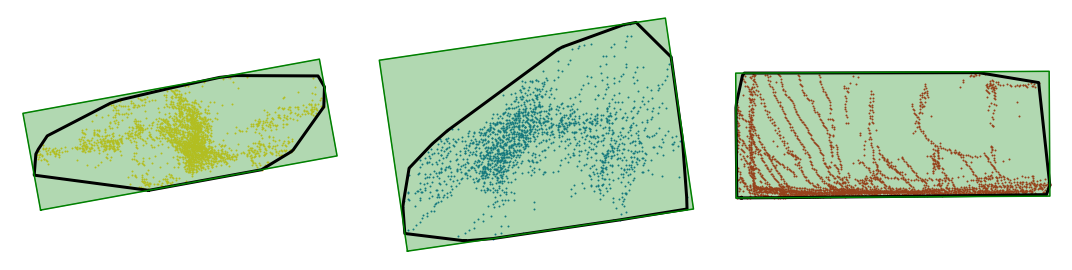

In [6]:
axes = plt.subplots(1, 3, figsize=(15, 4))[1]
cdict = dict(
    Cyclist=plt.get_cmap("Set2")(5),
    Pedestrian=plt.get_cmap("tab20")(0),
    Car=plt.get_cmap("tab20")(6),
)
for ax, name in zip(axes, cdict):
    pts = np.fromfile(f"./data/pa2_{name}.bin", dtype=np.float32).reshape(-1, 4)[:, :2]
    pts = pts[:, :2]
    convex_hull = get_convex_hull(pts)
    poly = pts[convex_hull]
    bbox = get_min_box(poly)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.scatter(pts[:, 0], pts[:, 1], s=1, color=cdict[name])
    ax.plot(
        np.concatenate([poly[:, 0], poly[:1, 0]]),
        np.concatenate([poly[:, 1], poly[:1, 1]]),
        c="k",
        linewidth=3,
    )
    ax.plot(
        np.concatenate([bbox[:, 0], bbox[:1, 0]]),
        np.concatenate([bbox[:, 1], bbox[:1, 1]]),
        c="g",
    )
    ax.fill(bbox[:, 0], bbox[:, 1], alpha=0.3, c="g")
plt.tight_layout()
plt.show()


运行下方代码展示3D结果.

In [7]:
def draw_poly(ax, x, y, z):
    vertices = [list(zip(x, y, z))]
    poly = Poly3DCollection(vertices, alpha=0.1, color="g")
    ax.add_collection3d(poly)


def draw_box3d(ax, bbox, z_min, z_max):
    draw_poly(ax, bbox[:, 0], bbox[:, 1], [z_min] * 4)
    draw_poly(ax, bbox[:, 0], bbox[:, 1], [z_max] * 4)
    for i in range(4):
        x = [bbox[i, 0], bbox[(i + 1) % 4, 0], bbox[(i + 1) % 4, 0], bbox[i, 0]]
        y = [bbox[i, 1], bbox[(i + 1) % 4, 1], bbox[(i + 1) % 4, 1], bbox[i, 1]]
        z = [z_min, z_min, z_max, z_max]
        draw_poly(ax, x, y, z)


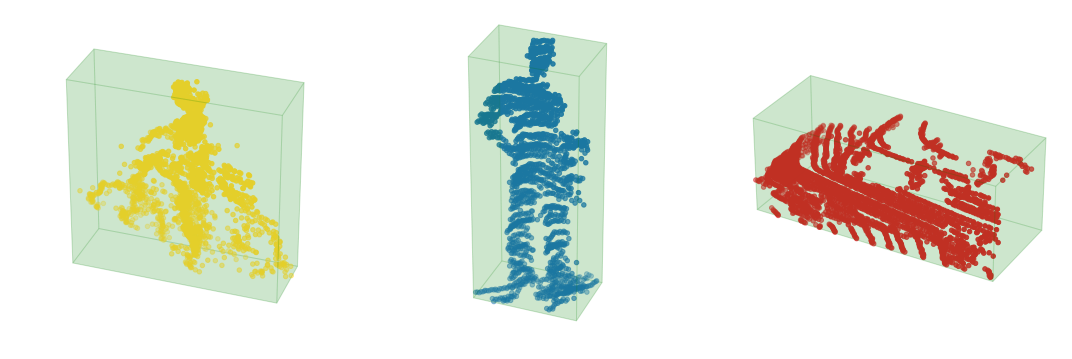

In [8]:
fig = plt.figure(figsize=(15, 15))
for i, name in enumerate(cdict):
    pts = np.fromfile(f"./data/pa2_{name}.bin", dtype=np.float32).reshape(-1, 4)
    z_min, z_max = pts[:, 2].min(), pts[:, 2].max()
    pts2d = pts[:, :2]
    convex_hull = get_convex_hull(pts2d)
    poly = pts2d[convex_hull]
    bbox = get_min_box(poly)
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    ax.axis("off")
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], color=cdict[name])
    draw_box3d(ax, bbox, z_min, z_max)
    ax.set_box_aspect(
        [ub - lb for lb, ub in (getattr(ax, f"get_{a}lim")() for a in "xyz")]
    )
plt.tight_layout()
plt.show()
